# Bent Fibre Adiabatic Aborber Layer #
PMLs are objectively cool. In addition, there are a few cool papers that implement a PML with the FDFD algorithm. For example:

https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-12-25-6165&id=81978#tbl01

But complex coordinate stretching and analytic continuations are way too elegant for the philsol philosophy (also I can't be bothered to do the algebra).
Instead, we can put on our physicist hats and bodge it. Fortunately we are not alone Johnson has already paved the way:

https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-16-15-11376&id=167814

In this notebook we test adiabatic absorption with a simple problem: bend loss from a step index fibre. We will use a few tricks to implement this problem. We will use antialiasing to improve on the geometry discretisation.   

The bend is implemented using a Stark like potential slope. This can be thought of a bit like a differential on a car. The path length of light on the outside of the bend is greater. To compensate for the additional accumulated phase we transform the refractive index.  

The refractive index can easily be defined in cylindrical polars. The Jacobian to transform between cylindrical and Cartesian:
$$
r dr d\theta dz = dx dy dz,
$$
implies a potential of the form:
$$
n_{R}(x,y) = (1 + \frac{x}{R}) n_\infty(x,y)
$$
where $n_\infty$ is the refractive index profile of the unbent fibre.


(0.0, 160.0, 0.0, 120.0)

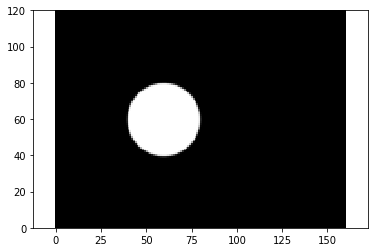

In [1]:
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFilter

import os 
os.chdir('../')

from philsol.classy import phil_class


%matplotlib inline



def Ref(lam):
    # Lets calculate the refractive index for fused silica
    
    B1 = 0.6961663
    B2 = 0.4079426
    B3 = 0.8974794
    C1 = 0.0684043**2
    C2 = 0.1162414 **2
    C3 = 9.896161**2
            
    n_square = ( 1  +  B1 * lam**2 / (lam**2 - C1) 
                    +  B2 * lam**2 / (lam**2 - C2) 
                    +  B3 * lam**2 / (lam**2 - C3) )
    
    return n_square**0.5 


def RefCore(lam):
    # Assume constant SMF-28 like aperture
    aperture = 0.14
    
    n_square = Ref(lam)**2 + aperture**2 
    
    return n_square**.5 


def FibreGeom(radius, dx, lam):
    # Lets borrow our antialiasing trick from the other example
    # parameter upscaling factor 
    scale = 100
    dx_scaled = dx / float(scale)
        
    R = int(radius / dx_scaled)
    
    num_x = 6 * R  
    num_y = 8 * R 
    geom = Image.new('F', (num_x, num_y), Ref(lam)) 
    geom_draw = ImageDraw.Draw(geom)
    geom_draw.ellipse([2*R, 2*R, 4*R, 4*R], RefCore(lam))
    
    new_size = tuple([round(dim / scale) for dim in np.array(geom.size)])
    
    #geom_R = geom.resize(new_size, Image.BICUBIC )
    geom_R = geom.resize(new_size, Image.LINEAR )
    
    new_size = np.flip(new_size)
    n = np.asarray(geom_R.getdata(), dtype = np.float64).reshape(new_size)
    n = n.transpose()
    
    return np.repeat(n[:,:,np.newaxis],3, axis = 2) 

plt.pcolormesh(FibreGeom(8.2, 8.2/20., 1.55)[:,:,0], cmap = 'Greys_r')
plt.axis('equal')    
    
    
    
#print(Ref(1.55))
#print(RefCore(1.55))
    

Now we have a simple function to make a fibre geometry we can introduce the slope potential to make the fibre bend.

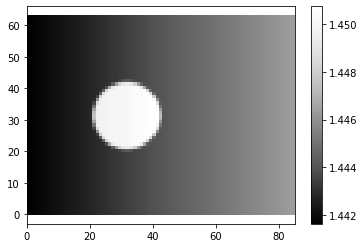

In [2]:
def TiltedGeom(diameter, radius, dx, lam):
    n = FibreGeom(radius, dx, lam)
    _,num_x,_ = np.shape(n)
    tilt = .25 * dx * num_x * np.linspace(-1, 1, num_x) / diameter
    return (1. + tilt[np.newaxis,:, np.newaxis]) * n 

plt.pcolormesh(TiltedGeom(1E4, 8.2, 1.55 / 2 , 1.55)[:,:,0], cmap = 'Greys_r')
plt.axis('equal')  
plt.colorbar()

Now comes the sketchy part. The idea behind this is that a PML is just a special example of adiabatic absorption. Now one of the things that makes it special is that by using a proper analytic transform you can absorb completely any outgoing radiation without reflection. However, Johnson claims that this isn't as useful as it seems because the discretization makes the absorption imperfect anyway.

Another way to think about it is with the adiabatic theorem. In hand wavy terms this basically means we introduce an absorption profile slowly enough compared to the phase oscillations that reflection is minimalized.  
Okay lets steal the absorption profile from the Johnson paper:  
$$
n_{PML} = n (1 - i e^{1-\frac{1}{u}})
$$
Where u is a function of x and y. The paper scientific justification as to why this is a good function to use. Apparently a PML would be a quadratic function here. 

We will apply this absorbing layer only on the outside of the bend.  
 


(63, 85, 3)
(44,)


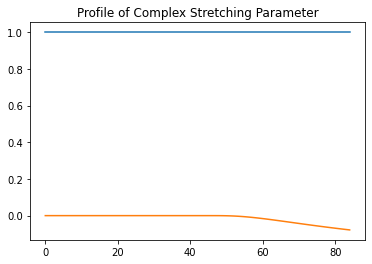

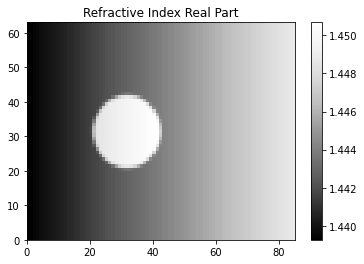

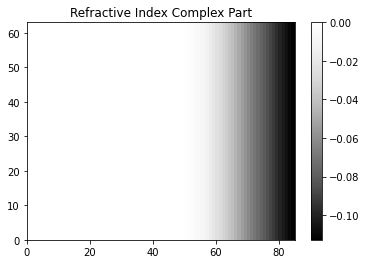

In [36]:
radius = 8.2
bendradius = 5E3

#dx = radius / float(radius_quant) 
wavelength = 1.55
dx = wavelength / 2 # Shannon sampling theorm yo 
radius_quant = round(radius / dx)

# Find the correct parameters here might take some experimentation 
A = .1
B = .8

n = TiltedGeom(bendradius, radius, dx,wavelength)
u = np.linspace(1.E-5, B, 4*radius_quant)
s_PML = 1. - 1j* A * np.exp(1. - 1./u) 
s = np.concatenate((np.ones(np.shape(n)[1] - 4* radius_quant), s_PML))
n = n * s[np.newaxis, :, np.newaxis] 

#u = np.zeros(6*radius_quant)
#s = (1. - 1j* np.exp(1. - 1./u[np.newaxis,:,np.newaxis])  )**.5


plt.figure()
plt.title('Profile of Complex Stretching Parameter')
plt.plot(s.real)
plt.plot(s.imag)



plt.figure()
plt.title('Refractive Index Real Part')
plt.pcolormesh(n[:,:,0].real, cmap = 'Greys_r')
plt.colorbar()

plt.figure()
plt.title('Refractive Index Complex Part')
plt.pcolormesh(n[:,:,0].imag, cmap = 'Greys_r')
plt.colorbar()

print(np.shape(n))
print(np.shape(u))




In [37]:
k  = 2 * cst.pi / wavelength
nmodes = 2

leakymodes = phil_class(n, k, dx = dx, dy = dx)

leakymodes.build_stuff()
leakymodes.solve_stuff(nmodes, k * RefCore(wavelength))



Assembling matrix for 5355 grid points...

and we are done (after 0.20949292182922363 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.6252880096435547 secs later we have the final solution.


<ipython-input-38-24b3c6387e8d>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(leakymodes.y, leakymodes.x, n[:,:,0].real, cmap = 'Greys_r')


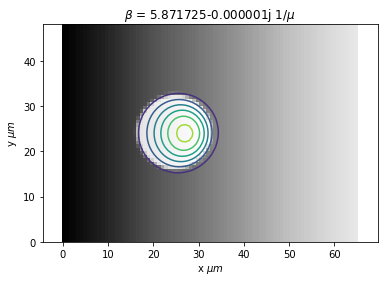

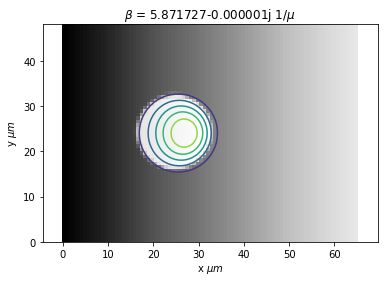

In [38]:
#print(supermodes.beta)
#print(np.shape(supermodes.Ey))

shape = np.insert(np.flip(np.shape(leakymodes.n)[:2]),0,nmodes)
E = leakymodes.Ex.reshape(shape)


for i in range(nmodes):
    plt.figure()
    title = r"$\beta$ = {:.6f} $1 / \mu$".format(leakymodes.beta[i])
    plt.title(title)
    plt.pcolormesh(leakymodes.y, leakymodes.x, n[:,:,0].real, cmap = 'Greys_r')
    E_plot = abs(np.squeeze(E[i,:,:]).transpose())
    plt.contour(leakymodes.y, leakymodes.x,E_plot)
    plt.xlabel('x $\mu m$')
    plt.ylabel('y $\mu m$')
    plt.axis('equal')
#plt.pcolormesh(E[0,:,:])


This seems sensible so lets try and replicate the losses quoted by the data sheet for Corning SMF-28. 

https://www.corning.com/optical-communications/emea/en/home/products/fiber/optical-fiber-products/smf-28-ultra.html 


| Bend Radius ($\mu m$) | Wavelength ($\mu m$) | Max Loss (dB) |
|----------------------|-------------|-----------|
|10000                 | 1550        | .5        |
|10000                 | 1625        | 1.5       |
|15000                 | 1550        | .005        |
|15000                 | 1625        | .03        |


In [35]:
bends = [1.E4, 1.E4, 1.5E4, 1.5E4]
wavelengths = [1.55, 1.625, 1.55, 1.625] 

losssweep = []
for bendradius, wl in zip(bends, wavelengths):
    k  = 2 * cst.pi / wl
    n = TiltedGeom(bendradius, radius, dx, wl) * s[np.newaxis, :, np.newaxis] 
    leakymodes = phil_class(n, k, dx = dx, dy = dx)
    leakymodes.build_stuff()
    leakymodes.solve_stuff(nmodes, 1.1* k * RefCore(wl))
    
    loss = 10 * np.log10(np.exp(2.* cst.pi* leakymodes.beta.imag * bendradius)) 
    print('\n\n-------------------------------------------')
    print('For wavelength = {:.2f}um and R = {:.2f}um'.format(wl, bendradius))
    print('We calculate a loss of {:f} dB'.format(-1*loss[0]))
    print('-------------------------------------------')

    

Assembling matrix for 5355 grid points...

and we are done (after 0.19985413551330566 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
2.485755443572998 secs later we have the final solution.


-------------------------------------------
For wavelength = 1.55um and R = 10000.00um
We calculate a loss of 0.085024 dB
-------------------------------------------
Assembling matrix for 5355 grid points...

and we are done (after 0.20194149017333984 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
2.051774263381958 secs later we have the final solution.


-------------------------------------------
For wavelength = 1.62um and R = 10000.00um
We calculate a loss of 0.119335 dB
-------------------------------------------
Assembling matrix for 5355 grid points...

and we are done (after 0.20150041580200195 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
2.2653322219848633 secs later we have the final solution.


-------------------

These numbers are not exactly what the data sheet says but they seem fairly reasonable to me. The most notable discrepency is $\lambda = 1.55\mu m$ , $R = 15mm$.   